Statistical QA Implementation

Below code block has the custom function defined that will take in the data frame and the users question. This will create the tfidf table for quesries and all the main article text terms. The calculate the similarity score between the query and the documents main article to create the ranked list of retrieved documents.

In [31]:
# imports for performing the ranked retrieval system

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import sqlite3

# Create the connection, load the data and close the connection
conn = sqlite3.connect('Modeler_output_topics_gensim.db')
df_corpus = pd.read_sql("SELECT * FROM topic_data_gensim;", conn)
conn.close()

# setting up the data frame to store Document - text mapping
corpus = df_corpus['main_article'].values.astype('U')  # Converting into unicode for consistancy

# Creating the Tfidf vectorizer model object and tunning the parameters
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english', # addition stop words removal for consistancy
    ngram_range=(1, 2),  # Using bigrams for more context
    max_df=0.85,         # Threshold to ignore repetetive words
    min_df=2,            # Threshold to ignore rare words
    norm='l2',           # Using l2 normalization for effecienty 
    use_idf=True         # Using idf weights
)

# Fitting and transforming the corpus into term frequency inverse document frequency matrix
tf_idf_m = tfidf_vectorizer.fit_transform(corpus)

# Custom function to process the user question and return top 5 ranked results using cosine similarity
def doc_retriever(question, top_n=5):
    
    # This variable will hold the vectorized user question
    u_ques_vec = tfidf_vectorizer.transform([question])
    
    # Using cosine similarity between the corpus and the question
    cosine_similarities = linear_kernel(u_ques_vec, tf_idf_m).flatten()
    
    # Sorting the list by the retrieved scores and returing last 5 results in decending order
    top_indices = cosine_similarities.argsort()[-top_n:][::-1]
    
    # Filtering the corpus to top indices from the similarity
    top_docs = df_corpus.iloc[top_indices][['highlights', 'topic_label']]
    top_docs['similarity_score'] = cosine_similarities[top_indices]  # Adding a column for similarity scores display
    
    return top_docs # retrun the final dataframe




In [32]:
df_corpus['topic_label'].value_counts()

topic_label
Law Enforcement and Public Safety        24
Politics and Society                     24
Social Issues and Health                 21
China and Global Affairs                 20
Conflict and Security                    20
Crime and Legal Proceedings              20
Sports and International Competitions    18
Sports and Events                        15
Political Leadership and Governance      14
International Relations and Politics     12
Religion and Cultural Affairs            12
Name: count, dtype: int64

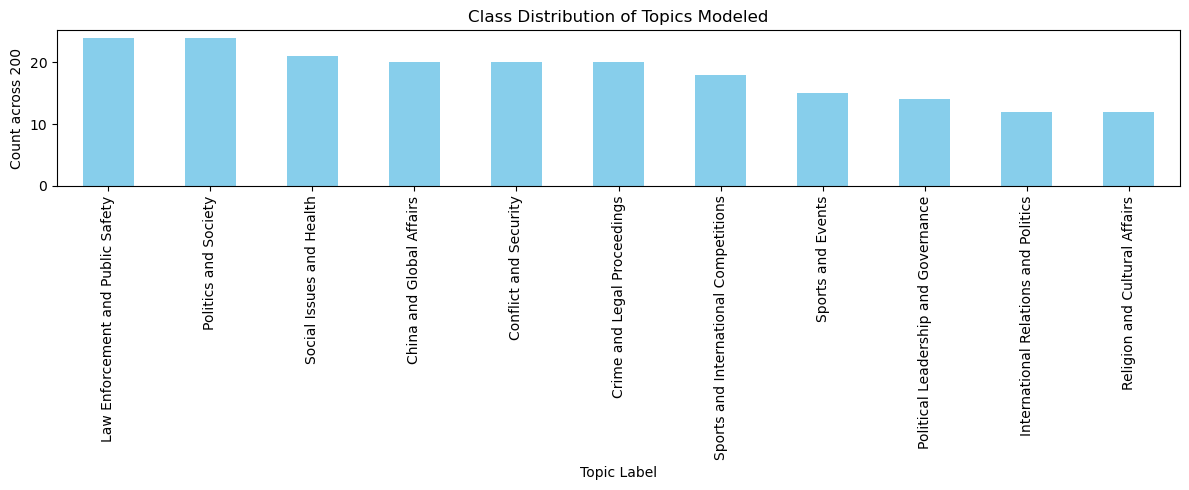

In [33]:
# viewing the class distribution

import matplotlib.pyplot as plt

# Plotting the class distribution for 'topic_label' using sklear bar plot
plt.figure(figsize=(12, 5)) # figure size
df_corpus['topic_label'].value_counts().plot(kind='bar', color='skyblue') # setting the bin with counts and the color to skyblue
plt.title('Class Distribution of Topics Modeled') # title
plt.xlabel('Topic Label')
plt.ylabel('Count across 200')
plt.tight_layout()
plt.show() # plot the bar

User query expansion to get more words to compare with documents. The expansion is done by splitting the terms in the query. Generating the relavent candidates with wordnet as well as lemmatizing the words.

In [34]:
import nltk
from textblob import TextBlob # spell correction module
from nltk.corpus import wordnet as wn # word net import

# Wordnet download
nltk.download('wordnet')

# custom function for spell correction
def correct_spelling(text):
    blob = TextBlob(text)
    return str(blob.correct())

# custom function to expand the users questions with wordnet
def expand_query(query):
    corrected_q = correct_spelling(query)
    expanded_query = corrected_q.split() # split the query
    for word in query.split():
        synonyms = wn.synsets(word) # getting the synonyms from wordnet corpus
        for syn in synonyms[:2]:  # limiting to 2 synonyms
            for lemma in syn.lemmas():
                expanded_query.append(lemma.name().replace('_', ' '))
    return ' '.join(set(expanded_query))  # using set to avoid duplicates




[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\8897p\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
from IPython.display import display

# Taking in the users question
u_ques = input("Ask a question").lower()
# apply the expansion on the users input
expanded_question = expand_query(u_ques)

# Apply the tfidf scoring function
top_results = doc_retriever(u_ques)

# Display with a blue gradint to view the score of the model tunned.
dis_df = top_results.style.background_gradient(subset=['similarity_score'], cmap='Blues') # adding blue gradiant to similarity scores
display(dis_df)


,highlights,topic_label,similarity_score
31,NEW France summons syria ambassador to protest an attack on its embassy US State Department official The syria government incites antiAmerican sentiment Also sundae a statebacked national dialogue meeting continued in damask's The bloodshed needs to stop Excessive force is unjustified one activist says,Crime and Legal Proceedings,0.584245
1,syria official mama climbed to the top of the tree doesn't know how to get down mama sends a letter to the heads of the House and Senate mama to seek congressional approval on military action against Syria Aim is to determine whether CW were used not by whom says in spokesman,Law Enforcement and Public Safety,0.540674
199,NEW At least 73 people are killed across Syria on sturdy opposition activists say in monitors arrive in tresses and find evidence of an attack An opposition group says more than 200 people were killed there Thursday The syria government blames the tresses incident on armed terrorist groups,Conflict and Security,0.433223
22,White House President mama has not decided on air strikes in Syria Possible options include air strikes on sis targets in Syria Some consider the group a direct threat to US security mama spent three years avoiding a US military role in Syria,Law Enforcement and Public Safety,0.431581
36,Comes as fresh pictures emerge from northern syria city of aleph in aftermath of alleged airstrike by government At least another 30 people died earlier in the week in violence across the country The latest suspected suicide bombing attack was the second in neighborhood of hare break,Law Enforcement and Public Safety,0.381344


Implementation of sentenceTransformer for comparision on the ranked retrieval task with the statistical model

Statistical Summary approach

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd

# Custom function to produce summaries based on the LSA algorithm
def lsa_summary_for_topics(df, topic_column='topic_label', text_column='highlights', num_phrases=25):
    # Storage for topic-wise summaries
    topic_summaries = {}

    # Grouping the DataFrame using the topic column
    grouped = df.groupby(topic_column)

    for topic, group in grouped:
        # Concatenating all highlights for the topic
        combined_text = ' '.join(group[text_column].dropna().values)

        # Validation check for combined text
        if not combined_text.strip():
            topic_summaries[topic] = "No content to summarize."
            continue

        # TF-IDF vectorization with improved parameter tuning
        try:
            tfidf_vectorizer_LSA = TfidfVectorizer(
                        
                sublinear_tf=True,             
                max_features=1500,      # Limit the vocabulary size to focus on informative words
                ngram_range=(1, 2),     # Use unigrams and bigrams
                stop_words='english' 
                
            )
            tfidf_matrix = tfidf_vectorizer_LSA.fit_transform([combined_text])
            
            # Normalizing the TF-IDF matrix using L2 normalization
            tfidf_matrix = normalize(tfidf_matrix, norm='l2')
            
            # Check for non-zero matrix sum to ensure meaningful content
            if tfidf_matrix.sum() == 0:
                topic_summaries[topic] = "No significant content to summarize."
                continue
        except ValueError as e:  # Exception handling for TF-IDF transformation errors
            print(f"Error with TF-IDF transformation for topic '{topic}': {e}")
            topic_summaries[topic] = "Error processing text."
            continue

        # Applying SVD for dimensionality reduction
        svd = TruncatedSVD(n_components=1)
        try:
            svd.fit(tfidf_matrix)
        except ValueError as e:  # Exception handling for SVD errors
            print(f"Error with SVD for topic '{topic}': {e}")
            topic_summaries[topic] = "Error processing text."
            continue

        # Extracting the most important words based on SVD components
        word_importances = svd.components_[0]
        feature_names = tfidf_vectorizer_LSA.get_feature_names_out()  # Get the feature names from the vectorizer

        # Creating a map for word importances to match feature names
        word_importance_pairs = [(feature_names[i], word_importances[i]) for i in range(len(word_importances))]
        
        # Sorting words by their importance
        word_importance_pairs.sort(key=lambda x: x[1], reverse=True)

        # Selecting the top words based on the specified num_phrases
        top_words = [pair[0] for pair in word_importance_pairs[:num_phrases]]

        # Filtering top words to include only those present in the original text
        top_words_in_text = [word for word in top_words if word in combined_text.split()]

        # Joining the top words to form the summary
        if top_words_in_text:
            summary = ' '.join(top_words_in_text)
        else:
            summary = "No valid summary generated."

        # Storing the topic summary
        topic_summaries[topic] = summary

    # Creating a DataFrame with topics and their summaries
    summary_df = pd.DataFrame(list(topic_summaries.items()), columns=[topic_column, 'summary'])
    return summary_df




In [37]:

from IPython.display import display

combined_summary = lsa_summary_for_topics(top_results)
display(combined_summary)


c:\Users\8897p\anaconda3\envs\nlp\lib\site-packages\sklearn\decomposition\_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


,topic_label,summary
0,Conflict and Security,killed opposition people syria tresses 200 73 ...
1,Crime and Legal Proceedings,syria activist ambassador attack bloodshed con...
2,Law Enforcement and Public Safety,syria mama air military strikes action afterma...


Below code is the implementation of the LSA algorithm with Word2Vec embeddings. Aim is to produce better summaries

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd
import gensim.downloader as api

# Loading the 100 D pretrianed WordToVec model to form word vectors for LSA summaries
word_vectors = api.load("glove-wiki-gigaword-100")  

# Custom function to produce summaries based on LSA and Word2Vec embeddings
def lsa_summary_gensim(df, topic_column='topic_label', text_column='highlights', num_phrases=25):
    # Storage for topic-wise summaries
    topic_summaries = {}

    # Grouping the DataFrame using the topic column
    grouped = df.groupby(topic_column)

    for topic, group in grouped:
        # Concatenating all highlights for the topic
        combined_text = ' '.join(group[text_column].dropna().values)

        # Validation check for combined text
        if not combined_text.strip():
            topic_summaries[topic] = "No content to summarize."
            continue

        # TF-IDF vectorization with improved parameter tuning
        try:
            tfidf_vectorizer_LSA = TfidfVectorizer(
                sublinear_tf=True,
                max_features=1500,      # Limit the vocabulary size to focus on informative words
                ngram_range=(1, 2),     # Using unigrams and bigrams
                stop_words='english'
            )
            tfidf_matrix = tfidf_vectorizer_LSA.fit_transform([combined_text]) # fitting the vectorizer
            
            # Normalizing the TF-IDF matrix using L2 normalization
            tfidf_matrix = normalize(tfidf_matrix, norm='l2')
            
            # Check for non-zero matrix sum to ensure meaningful content
            if tfidf_matrix.sum() == 0:
                topic_summaries[topic] = "No significant content to summarize."
                continue
        except ValueError as e:  # Exception handling for TF-IDF transformation errors
            print(f"Error with TF-IDF transformation for topic '{topic}': {e}")
            topic_summaries[topic] = "Error processing text."
            continue

        # Applying SVD for dimensionality reduction
        svd = TruncatedSVD(n_components=1)
        try:
            svd.fit(tfidf_matrix)
        except ValueError as e:  # Exception handling for SVD errors
            print(f"Error with SVD for topic '{topic}': {e}")
            topic_summaries[topic] = "Error processing text."
            continue

        # Extracting the most important words based on SVD components
        word_importances = svd.components_[0]
        feature_names = tfidf_vectorizer_LSA.get_feature_names_out()  # Get the feature names from the vectorizer

        # Creating a map for word importances to match feature names
        word_importance_pairs = [(feature_names[i], word_importances[i]) for i in range(len(word_importances))]
        
        # Sorting words by their importance
        word_importance_pairs.sort(key=lambda x: x[1], reverse=True)

        # Selecting the top words based on the specified num_phrases
        top_words = [pair[0] for pair in word_importance_pairs[:num_phrases]]

        # The top words in the embedding will be used
        top_words_with_embeddings = [word for word in top_words if word in word_vectors]
        
        # Joining the top words from embeddings to get the summary
        if top_words_with_embeddings:
            summary = ' '.join(top_words_with_embeddings)
        else:
            summary = "No valid summary generated."

        # Storing the topic summary
        topic_summaries[topic] = summary

    # Creating a DataFrame with topics and their summaries
    summary_df = pd.DataFrame(list(topic_summaries.items()), columns=[topic_column, 'summary'])
    return summary_df


In [39]:
combined_summary_gensim = lsa_summary_gensim(top_results)
display(combined_summary_gensim)


c:\Users\8897p\anaconda3\envs\nlp\lib\site-packages\sklearn\decomposition\_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


,topic_label,summary
0,Conflict and Security,killed opposition people syria tresses 200 73 ...
1,Crime and Legal Proceedings,syria activist ambassador attack bloodshed con...
2,Law Enforcement and Public Safety,syria mama air house military strikes action a...


A comparision between  the LSA and LSA + Word to Vec model
Using Jaccrd

In [40]:
import pandas as pd

# 
comparison_df = pd.merge(
    combined_summary,
    combined_summary_gensim,
    on='topic_label',
    suffixes=('_lsa', '_lsa_w2v') # label suffixes
)

# Custom function that will calculate the similarity between the words
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Calculate Jaccard similarity for each pair of summaries
comparison_df['jaccard_similarity'] = comparison_df.apply( # iteratively find the jaccards similarities between the summaries
    lambda row: jaccard_similarity(
        set(row['summary_lsa'].split()), 
        set(row['summary_lsa_w2v'].split())
    ),
    axis=1
)

# Generating the comparision values and printing the average score.
average_jaccard_score = comparison_df['jaccard_similarity'].mean() # mean of all the jaccard similarity scores from LSA and Gensim+LSA
print(f"Average Jaccard similarity between LSA and LSA + Word2Vec summaries: {average_jaccard_score:.2f}")


Average Jaccard similarity between LSA and LSA + Word2Vec summaries: 0.87


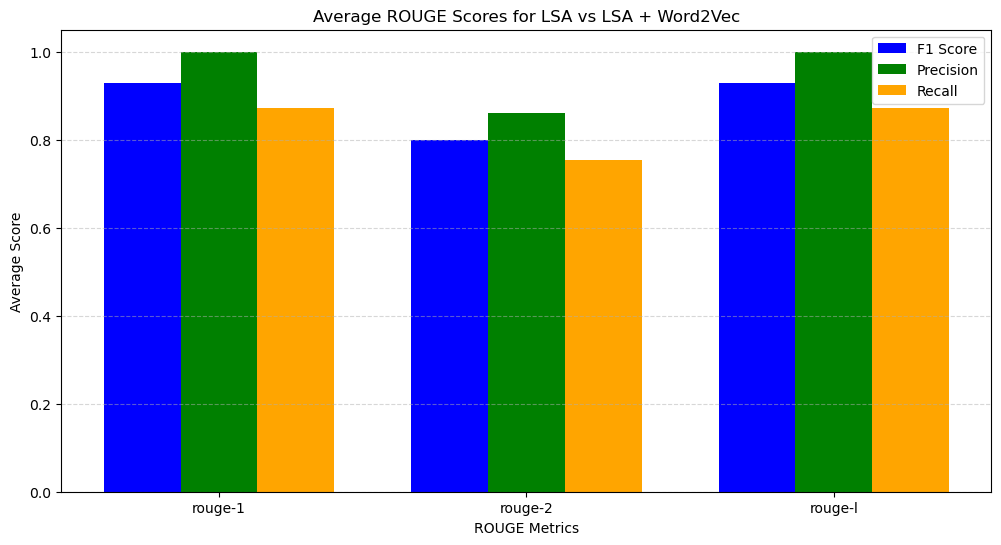

In [41]:
import matplotlib.pyplot as plt
from rouge import Rouge

# Initializing the rouge function
rouge = Rouge()
scores = []

# Comparing LSA and LSA + WVec summaries
for i, row in comparison_df.iterrows():
    score = rouge.get_scores(row['summary_lsa'], row['summary_lsa_w2v'], avg=True)
    scores.append(score)

# variable for avg scores and length of retrieved scores
avg_scores = {}
num_scores = len(scores)

# Aggregating scores from the list of dictionaries
for metric_group in scores:
    for metric, values in metric_group.items():
        if metric not in avg_scores:
            avg_scores[metric] = {'f': 0, 'p': 0, 'r': 0}
        avg_scores[metric]['f'] += values['f']
        avg_scores[metric]['p'] += values['p']
        avg_scores[metric]['r'] += values['r']

# Compute the average for each metric
averages = {'f': [], 'p': [], 'r': []}
metrics = []

#loop through the metrics
for metric, value_dict in avg_scores.items():
    metrics.append(metric)
    avg_f = value_dict['f'] / num_scores if num_scores else 0
    avg_p = value_dict['p'] / num_scores if num_scores else 0
    avg_r = value_dict['r'] / num_scores if num_scores else 0
    averages['f'].append(avg_f)
    averages['p'].append(avg_p)
    averages['r'].append(avg_r)


x = range(len(metrics))
width = 0.25  
# plotting the multiple bar graph for comparision
plt.figure(figsize=(12, 6))
plt.bar([pos - width for pos in x], averages['f'], width=width, label='F1 Score', color='blue')
plt.bar(x, averages['p'], width=width, label='Precision', color='green')
plt.bar([pos + width for pos in x], averages['r'], width=width, label='Recall', color='orange')

# Metric labels
plt.xticks(x, metrics)
plt.xlabel('ROUGE Metrics')
plt.ylabel('Average Score')
plt.title('Average ROUGE Scores for LSA vs LSA + Word2Vec')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# display the plot
plt.show()


In [ ]:
# Call cell for Streamlit app
#!streamlit run stat_model_deploy_v2.py

Below code block is to run the pipline on the pretranied transformers. This is to produce results and compare with the statistical pipe line


In [43]:
# Importing transformes
import pandas as pd
import sqlite3
import torch
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
from rouge import Rouge

# Loading the sentence model and the sql data
def load_model_and_data():
    model = SentenceTransformer('all-MiniLM-L6-v2')
    conn = sqlite3.connect('Modeler_output_topics_gensim.db')
    df_corpus = pd.read_sql("SELECT * FROM topic_data_gensim;", conn)
    conn.close()
    corpus = df_corpus['main_article'].values.astype('U')
    corpus_embeddings = model.encode(corpus, convert_to_tensor=True)
    return model, df_corpus, corpus_embeddings

model, df_corpus, corpus_embeddings = load_model_and_data()

# Custom funtion for retrieval
def doc_retriever(question, top_n=5):
    question_embedding = model.encode(question, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(question_embedding, corpus_embeddings)[0]
    top_indices = torch.topk(cosine_scores, k=top_n).indices.tolist()
    top_docs = df_corpus.iloc[top_indices][['highlights', 'topic_label']]
    top_docs['similarity_score'] = cosine_scores[top_indices].tolist()
    return top_docs

# Ask the input question
user_question = input("Enter your question: ")

# if valid
if user_question:
    result_transformer = doc_retriever(user_question, top_n=5)
    print("Top 5 Retrieved Documents:")
    for i, row in result_transformer.iterrows():
        print(f"\nDocument {i+1} (Topic: {row['topic_label']})")
        print(f"Similarity Score: {row['similarity_score']:.4f}")
    
    # Summarizing the  grouped highlights using face book BART
    grouped_highlights = result_transformer.groupby('topic_label')['highlights'].apply(lambda x: ' '.join(x)).reset_index()
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

    # print the results generated
    print("\nGenerating topic-wise summaries...")
    grouped_highlights['summary'] = grouped_highlights['highlights'].apply(
        lambda text: summarizer(text, max_length=80, min_length=40, do_sample=False)[0]['summary_text']
    )

    tansformer_df = grouped_highlights
    # topic vice
    for _, row in tansformer_df.iterrows():
        print(f"\nTopic: {row['topic_label']}")
        print(f"Summary: {row['summary']}")

Top 5 Retrieved Documents:

Document 134 (Topic: Law Enforcement and Public Safety)
Similarity Score: 0.4655

Document 200 (Topic: Conflict and Security)
Similarity Score: 0.4448

Document 23 (Topic: Law Enforcement and Public Safety)
Similarity Score: 0.4391

Document 197 (Topic: Politics and Society)
Similarity Score: 0.4324

Document 32 (Topic: Crime and Legal Proceedings)
Similarity Score: 0.4285


Your max_length is set to 80, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)



Generating topic-wise summaries...


Your max_length is set to 80, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 80, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)



Topic: Conflict and Security
Summary: At least 73 people are killed across Syria on Thursday. Opposition activists say in monitors arrive in tresses and find evidence of an attack. Government blames the tresses incident on armed terrorist groups.

Topic: Crime and Legal Proceedings
Summary: France summons syria ambassador to protest an attack on its embassy. The syria government incites antiAmerican sentiment. A statebacked national dialogue meeting continued in damask's The bloodshed needs to stop.

Topic: Law Enforcement and Public Safety
Summary: President brogan warns bani is about to fall to sis. Canada will send fighter jets to target sis in Iraq in envoy. Some consider the group a direct threat to US security.

Topic: Politics and Society
Summary: US evidence includes satellite imagery official says mama is considering how to respond to syria chemical attack. Official mama could be presented with options within days. A US strike cant just be one and done, analyst says.


In [ ]:
import pandas as pd

# 
comparison_df_st = pd.merge(
    tansformer_df,
    combined_summary_gensim,
    on='topic_label',
    suffixes=('_transformer', '_lsa_w2v') # label suffixes
)

# Custom function that will calculate the similarity between the words
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Calculate Jaccard similarity for each pair of summaries
comparison_df_st['jaccard_similarity'] = comparison_df_st.apply( # iteratively find the jaccards similarities between the summaries
    lambda row: jaccard_similarity(
        set(row['summary_transformer'].split()), 
        set(row['summary_lsa_w2v'].split())
    ),
    axis=1
)

# Generating the comparision values and printing the average score.
average_jaccard_score = comparison_df_st['jaccard_similarity'].mean() # mean of all the jaccard similarity scores from pretrain and Gensim+LSA
print(f"Average Jaccard similarity between Pretain and LSA + Word2Vec summaries: {average_jaccard_score:.2f}")


Average Jaccard similarity between Pretain and LSA + Word2Vec summaries: 0.14


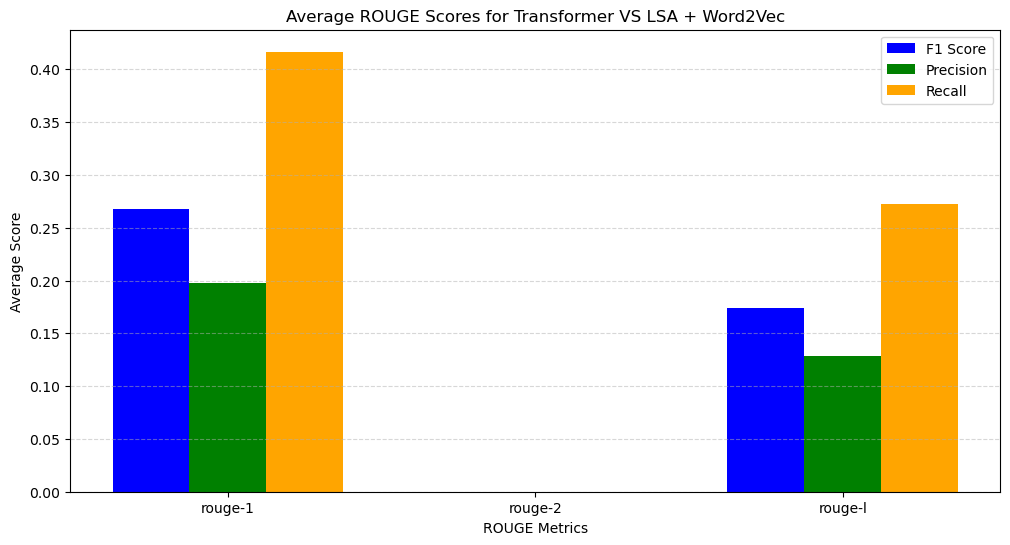

In [ ]:
import matplotlib.pyplot as plt
from rouge import Rouge

# Initializing the rouge function
rouge = Rouge()
scores = []

# Comparing Pretrain and LSA + WVec summaries
for i, row in comparison_df_st.iterrows():
    score = rouge.get_scores(row['summary_transformer'], row['summary_lsa_w2v'], avg=True)
    scores.append(score)

# variable for avg scores and length of retrieved scores
avg_scores = {}
num_scores = len(scores)

# Aggregating scores from the list of dictionaries
for metric_group in scores:
    for metric, values in metric_group.items():
        if metric not in avg_scores:
            avg_scores[metric] = {'f': 0, 'p': 0, 'r': 0}
        avg_scores[metric]['f'] += values['f']
        avg_scores[metric]['p'] += values['p']
        avg_scores[metric]['r'] += values['r']

# Compute the average for each metric
averages = {'f': [], 'p': [], 'r': []}
metrics = []

#loop through the metrics
for metric, value_dict in avg_scores.items():
    metrics.append(metric)
    avg_f = value_dict['f'] / num_scores if num_scores else 0
    avg_p = value_dict['p'] / num_scores if num_scores else 0
    avg_r = value_dict['r'] / num_scores if num_scores else 0
    averages['f'].append(avg_f)
    averages['p'].append(avg_p)
    averages['r'].append(avg_r)


x = range(len(metrics))
width = 0.25  
# plotting the multiple bar graph for comparision
plt.figure(figsize=(12, 6))
plt.bar([pos - width for pos in x], averages['f'], width=width, label='F1 Score', color='blue')
plt.bar(x, averages['p'], width=width, label='Precision', color='green')
plt.bar([pos + width for pos in x], averages['r'], width=width, label='Recall', color='orange')

# Metric labels
plt.xticks(x, metrics)
plt.xlabel('ROUGE Metrics')
plt.ylabel('Average Score')
plt.title('Average ROUGE Scores for Transformer VS LSA + Word2Vec')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# display the plot
plt.show()


In [49]:
# Call cell for Streamlit app
!streamlit run pre_train_deploy.py

^C
